In [86]:
import pandas as pd
import numpy as np
import torch
from sklearn import preprocessing
from dgl.data import DGLDataset
import dgl
import time
import networkx as nx
import category_encoders as ce
import torch.nn as nn
import torch.nn.functional as F
import dgl.function as fn
import torch
import tqdm
import math

from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score,f1_score

from typing import *
from sklearn.preprocessing import StandardScaler, Normalizer
import socket
import struct
import random
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")

In [87]:
df_train = pd.read_parquet("train_embedded.parquet")
df_test = pd.read_parquet("test_embedded.parquet")

train_labels = df_train["Label"]
test_labels = df_test["Label"]

train_samples  = df_train.drop(columns=["Label", "Attack"])
test_samples = df_test.drop(columns=["Label", "Attack"])

In [4]:
corr_labels = train_samples.corrwith(train_labels)
desc_list_corr = (corr_labels).argsort().values

col_keep_ratio = 100
cols_to_keep = desc_list_corr[:len(desc_list_corr)*col_keep_ratio//100 ]
cols_to_keep = [str(i) for i in cols_to_keep]
train_samples = train_samples[cols_to_keep]
test_samples = test_samples[cols_to_keep]

In [5]:
df_train_xai = pd.read_parquet("graph_explainers_df.parquet")

In [6]:
def train_and_test(explainer_name, ratio_perc_to_keep, train_samples, train_labels, test_samples, test_labels, sorted_list):
    selected_samples = sorted_list[:len(sorted_list)*ratio_perc_to_keep//100]
    X_train = train_samples.loc[selected_samples]
    Y_train = train_labels.loc[selected_samples]
    X_test = test_samples
    Y_test = test_labels
    X_scaler = StandardScaler()
    X_train = X_scaler.fit_transform(X_train)
    X_test = X_scaler.transform(X_test)
    model = CatBoostClassifier(iterations=250,
                            learning_rate=0.1,
                            depth=3,
                            verbose=0)
    try:
        model.fit(X_train, Y_train)
    except Exception as e:
        print(f"Error on {explainer_name} {ratio_perc_to_keep} : {e} ")
        return {
        'dataset': ratio_perc_to_keep,
        'model': explainer_name,
        'acc': None,
        'f1_macro': None,
        'precision': None,
        'recall': None
    }
    Y_predicted = model.predict(X_test)
    return {
        'dataset': ratio_perc_to_keep,
        'model': explainer_name,
        'acc': accuracy_score(Y_test,Y_predicted),
        'f1_macro': f1_score(Y_test, Y_predicted, average='macro'),
        'precision': precision_score(Y_test,Y_predicted),
        'recall': recall_score(Y_test,Y_predicted)
    }

In [60]:
df_results = []
sorted_list = df_train_xai.sort_values(by=['GNNExplainer']).index
for i in tqdm.tqdm(range(10,96,5)):
    print("Running", i)
    df_results.append(train_and_test("GNNExplainer", i , train_samples, train_labels, test_samples, test_labels, sorted_list))

  0%|                                                                                              | 0/18 [00:00<?, ?it/s]

Running 10


  6%|████▊                                                                                 | 1/18 [00:06<01:43,  6.07s/it]

Running 15


 11%|█████████▌                                                                            | 2/18 [00:14<01:59,  7.44s/it]

Running 20


 17%|██████████████▎                                                                       | 3/18 [00:24<02:12,  8.84s/it]

Running 25


 22%|███████████████████                                                                   | 4/18 [00:37<02:24, 10.30s/it]

Running 30


 28%|███████████████████████▉                                                              | 5/18 [00:51<02:33, 11.81s/it]

Running 35


 33%|████████████████████████████▋                                                         | 6/18 [01:08<02:40, 13.40s/it]

Running 40


 39%|█████████████████████████████████▍                                                    | 7/18 [01:26<02:45, 15.02s/it]

Running 45


 44%|██████████████████████████████████████▏                                               | 8/18 [01:47<02:47, 16.76s/it]

Running 50


 50%|███████████████████████████████████████████                                           | 9/18 [02:09<02:46, 18.52s/it]

Running 55


 56%|███████████████████████████████████████████████▏                                     | 10/18 [02:34<02:43, 20.38s/it]

Running 60


 61%|███████████████████████████████████████████████████▉                                 | 11/18 [03:00<02:35, 22.23s/it]

Running 65


 67%|████████████████████████████████████████████████████████▋                            | 12/18 [03:29<02:25, 24.18s/it]

Running 70


 72%|█████████████████████████████████████████████████████████████▍                       | 13/18 [04:00<02:10, 26.17s/it]

Running 75


 78%|██████████████████████████████████████████████████████████████████                   | 14/18 [04:32<01:52, 28.07s/it]

Running 80


 83%|██████████████████████████████████████████████████████████████████████▊              | 15/18 [05:07<01:30, 30.16s/it]

Running 85


 89%|███████████████████████████████████████████████████████████████████████████▌         | 16/18 [05:44<01:04, 32.19s/it]

Running 90


 94%|████████████████████████████████████████████████████████████████████████████████▎    | 17/18 [06:23<00:34, 34.31s/it]

Running 95


100%|█████████████████████████████████████████████████████████████████████████████████████| 18/18 [07:05<00:00, 23.63s/it]


In [62]:
pd.DataFrame(df_results)

,dataset,model,acc,f1_macro,precision,recall
0,10,GNNExplainer,0.994729,0.987265,0.998599,0.957302
1,15,GNNExplainer,0.994803,0.987444,0.998753,0.957767
2,20,GNNExplainer,0.994537,0.986788,0.998789,0.955509
3,25,GNNExplainer,0.994766,0.987351,0.998853,0.957362
4,30,GNNExplainer,0.994759,0.987336,0.998868,0.957295
5,35,GNNExplainer,0.994753,0.987321,0.998829,0.957280
6,40,GNNExplainer,0.994634,0.987025,0.998990,0.956129
7,45,GNNExplainer,0.994634,0.987026,0.998921,0.956195
8,50,GNNExplainer,0.994525,0.986758,0.998920,0.955288
9,55,GNNExplainer,0.994601,0.986946,0.998843,0.955996


In [74]:
sorted_list = df_train_xai.sort_values(by=['PGExplainer']).index
for i in tqdm.tqdm(range(10,96,5)):
    print("Running", i)
    df_results.append(train_and_test("PGExplainer", i , train_samples, train_labels, test_samples, test_labels, sorted_list))

  0%|                                                                                              | 0/18 [00:00<?, ?it/s]

Running 10


  6%|████▊                                                                                 | 1/18 [00:05<01:37,  5.73s/it]

Running 15


 11%|█████████▌                                                                            | 2/18 [00:13<01:50,  6.93s/it]

Running 20


 17%|██████████████▎                                                                       | 3/18 [00:23<02:05,  8.39s/it]

Running 25


 22%|███████████████████                                                                   | 4/18 [00:35<02:17,  9.83s/it]

Running 30


 28%|███████████████████████▉                                                              | 5/18 [00:49<02:26, 11.30s/it]

Running 35


 33%|████████████████████████████▋                                                         | 6/18 [01:05<02:33, 12.78s/it]

Running 40


 39%|█████████████████████████████████▍                                                    | 7/18 [01:23<02:41, 14.69s/it]

Running 45


 44%|██████████████████████████████████████▏                                               | 8/18 [01:43<02:44, 16.43s/it]

Running 50


 50%|███████████████████████████████████████████                                           | 9/18 [02:06<02:44, 18.32s/it]

Running 55


 56%|███████████████████████████████████████████████▏                                     | 10/18 [02:31<02:42, 20.32s/it]

Running 60


 61%|███████████████████████████████████████████████████▉                                 | 11/18 [02:57<02:35, 22.27s/it]

Running 65


 67%|████████████████████████████████████████████████████████▋                            | 12/18 [03:26<02:25, 24.27s/it]

Running 70


 72%|█████████████████████████████████████████████████████████████▍                       | 13/18 [03:57<02:10, 26.17s/it]

Running 75


 78%|██████████████████████████████████████████████████████████████████                   | 14/18 [04:30<01:53, 28.26s/it]

Running 80


 83%|██████████████████████████████████████████████████████████████████████▊              | 15/18 [05:05<01:30, 30.22s/it]

Running 85


 89%|███████████████████████████████████████████████████████████████████████████▌         | 16/18 [05:42<01:04, 32.38s/it]

Running 90


 94%|████████████████████████████████████████████████████████████████████████████████▎    | 17/18 [06:22<00:34, 34.55s/it]

Running 95


100%|█████████████████████████████████████████████████████████████████████████████████████| 18/18 [07:04<00:00, 23.56s/it]


In [73]:
pd.DataFrame(df_results)

,dataset,model,acc,f1_macro,precision,recall
0,10,GNNExplainer,0.994729,0.987265,0.998599,0.957302
1,15,GNNExplainer,0.994803,0.987444,0.998753,0.957767
2,20,GNNExplainer,0.994537,0.986788,0.998789,0.955509
3,25,GNNExplainer,0.994766,0.987351,0.998853,0.957362
4,30,GNNExplainer,0.994759,0.987336,0.998868,0.957295
5,35,GNNExplainer,0.994753,0.987321,0.998829,0.957280
6,40,GNNExplainer,0.994634,0.987025,0.998990,0.956129
7,45,GNNExplainer,0.994634,0.987026,0.998921,0.956195
8,50,GNNExplainer,0.994525,0.986758,0.998920,0.955288
9,55,GNNExplainer,0.994601,0.986946,0.998843,0.955996


In [59]:
#sorted_list = df_train_xai.sort_values(by=['SHAP']).index
#for i in tqdm.tqdm(range(35,96,5)):
#    print("Running", i)
#    df_results.append(train_and_test("SHAP", i , train_samples, train_labels, test_samples, test_labels, sorted_list))

In [75]:
#last
acc_ref=0.994784
f1_macro_ref=0.987396
precision_ref=0.998953
recall_ref=0.957421

In [76]:
#old
#acc_ref=0.993922
#f1_macro_ref=0.985285
#precision_ref=0.997386
#recall_ref=0.951708

In [77]:
#pd.set_option("display.precision", 5)

In [ ]:
pdf_results = pd.DataFrame(df_results)
pdf_results["acc_drop"] = (acc_ref - pdf_results["acc"]) / acc_ref
pdf_results["f1_macro_drop"] = (f1_macro_ref - pdf_results["f1_macro"]) / f1_macro_ref
pdf_results["precision_drop"] = (precision_ref - pdf_results["precision"]) / precision_ref
pdf_results["recall_drop"] = (recall_ref - pdf_results["recall"]) / recall_ref

pdf_results

In [79]:
#pdf_results= pd.read_csv("pdf_results-Copy1.csv")

#pdf_results["acc_drop"]  = pdf_results["acc_drop"].abs()
#pdf_results["f1_macro_drop"]  = pdf_results["f1_macro_drop"].abs()
#pdf_results["precision_drop"]  = pdf_results["precision_drop"].abs()
#pdf_results["recall_drop"]  = pdf_results["recall_drop"].abs()


In [80]:
pdf_results.to_csv('pdf_results_22102218.csv')

In [81]:
pdf_results=pdf_results[(pdf_results.model=="GNNExplainer") | (pdf_results.model=="PGExplainer")]
#pdf_results=pdf_results[(pdf_results.dataset==25) | (pdf_results.dataset==50) | (pdf_results.dataset==75) | (pdf_results.dataset==95)]

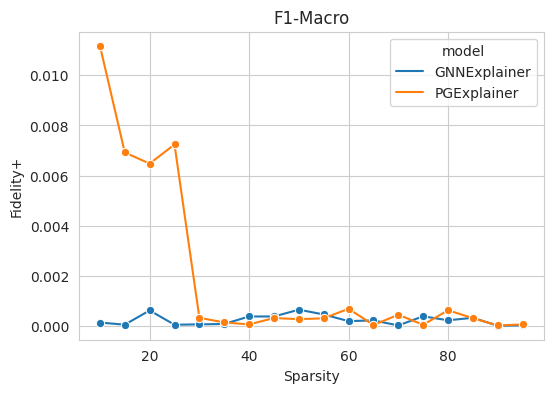

In [82]:
plt.figure(figsize=(6,4))
sns.set_style(style='whitegrid') 
ax = sns.lineplot(
    data=pdf_results[(pdf_results.model=="GNNExplainer") | (pdf_results.model=="PGExplainer")],
    x='dataset', 
    y='f1_macro_drop', 
    marker="o",
    hue="model"

)
#plt.ylim((-0.11),1.25)
ax.set(xlabel ="Sparsity", ylabel = "Fidelity+", title = "F1-Macro")
plt.show()
fig = ax.get_figure()
fig.savefig("f1_drop.png")

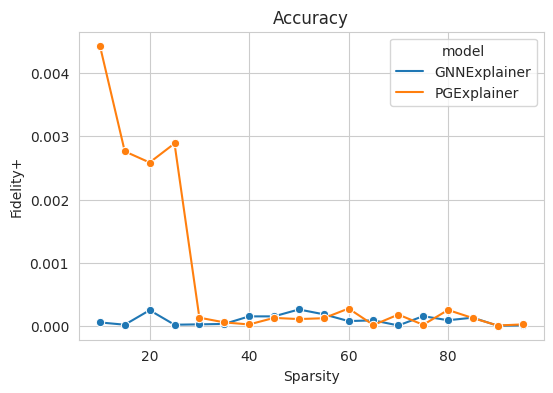

In [83]:
plt.figure(figsize=(6,4))
sns.set_style(style='whitegrid') 
ax = sns.lineplot(
    data=pdf_results[(pdf_results.model=="GNNExplainer") | (pdf_results.model=="PGExplainer")], 
    x='dataset', 
    y='acc_drop', 
    marker="o",
    hue="model"
)

#plt.ylim((-0.1),0.6)
ax.set(xlabel ="Sparsity", ylabel = "Fidelity+", title = "Accuracy")
plt.show()
fig = ax.get_figure()
fig.savefig("acc_drop.png")


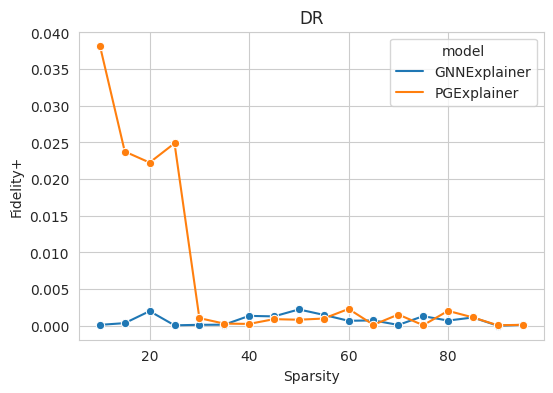

In [84]:
plt.figure(figsize=(6,4))
sns.set_style(style='whitegrid') 
ax = sns.lineplot(
    data=pdf_results[(pdf_results.model=="GNNExplainer") | (pdf_results.model=="PGExplainer")], 
    x='dataset', 
    y='recall_drop', 
    marker="o",
    hue="model",
)

#plt.ylim((-0.5),1.25)
ax.set(xlabel ="Sparsity", ylabel = "Fidelity+", title = "DR")
plt.show()
fig = ax.get_figure()
fig.savefig("recall_drop.png")
